# Lab | Web Scraping

Welcome to the IMDb Web Scraping Adventure Lab!

**Objective**

In this lab, we will embark on a mission to unearth valuable insights from the vast sea of data available on IMDb, one of the largest online databases of movie, TV, and celebrity information. As budding data scientists and business analysts, you have been tasked to scrape a specific subset of data from IMDb to assist film production companies in understanding the landscape of highly-rated movies in a defined time period. Your insights will potentially influence the making of the next netflix movie!

**Background**

In a world where data is the new currency, businesses are leveraging big data to make informed decisions that drive success and profitability. The entertainment industry, being no exception, utilizes data analytics to comprehend market trends, audience preferences, and the performance of films based on various parameters such as director, genre, stars involved, etc. IMDb stands as a goldmine of such data, offering intricate details of almost every movie ever made.

**Task**

Your task is to create a Python script using `BeautifulSoup` and `pandas` to scrape IMDb movie data based on user ratings and release dates. This script should be able to filter movies with ratings above a certain threshold and within a specified date range.

**Expected Outcome**

- A function named `scrape_imdb` that takes four parameters: `title_type`,`user_rating`, `start_date`, and `end_date`.
- The function should return a DataFrame with the following columns:
  - **Movie Nr**: The number representing the movie’s position in the list.
  - **Title**: The title of the movie.
  - **Year**: The year the movie was released.
  - **Rating**: The IMDb rating of the movie.
  - **Runtime (min)**: The duration of the movie in minutes.
  - **Genre**: The genre of the movie.
  - **Description**: A brief description of the movie.
  - **Director**: The director of the movie.
  - **Stars**: The main stars of the movie.
  - **Votes**: The number of votes the movie received.
  - **Gross ($M)**: The gross earnings of the movie in millions of USD.

You will execute this script to scrape data of movies with Title Type `Feature Film` having a user rating of `7.5 and above`, released between `January 1, 1990, and December 31, 1992.`

Remember to experiment with different title types, dates and ratings to ensure your code is versatile and can handle various searches effectively!

**Resources**

- [Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
- [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/index.html)
- [IMDb Advanced Search](https://www.imdb.com/search/title/)


**Hint**

Your first mission is to familiarize yourself with the IMDb advanced search page. Head over to [IMDb advanced search](https://www.imdb.com/search/title/) and input the following parameters, keeping all other fields to their default values or blank:

- **Title Type**: Feature film
- **Release date**: From 1990 to 1992 (Note: You don't need to specify the day and month)
- **User Rating**: 7.5 to -

Upon searching, you'll land on a page showcasing a list of movies, each displaying vital details such as the title, release year, and crew information. Your task is to scrape this treasure trove of data.

Look at the resulting URL to construct your URL carefully to include all the necessary parameters for filtering the movies. 


---

**Best of luck! Immerse yourself in the world of movies and may the data be with you!**

**Important note**: 

In the fast-changing online world, websites often get updates and make changes. When you try this lab, the IMDb website might be different from what we expect. **These changes could make it hard to use the solutions we provide here.**

If you run into problems because of these changes, like new rules or things that stop you from getting data, don't worry! Instead, get creative.

You can choose another website that interests you and is good for scraping data. Websites like Wikipedia or The New York Times are good options. The main goal is still the same: get useful data and learn how to scrape it from a website that you find interesting. It's a chance to practice your web scraping skills and explore a source of information you like.

In [2]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
}

In [3]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

title_type='feature'
user_rating='7.5'
start_date='1990-01-01'
end_date='1992-12-31'


url = f"https://www.imdb.com/search/title/?title_type={title_type}&release_date={start_date},{end_date}&user_rating={user_rating},10"

response = requests.get(url,headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

movies = []

for div in soup.find_all('li', class_='ipc-metadata'):
    # Get movie details
    nr = div.find('span', class_='lister-item-index unbold text-primary').text.strip('.').strip()
    title = div.find('h3').find('a').text.strip()
    year = div.find('span', class_='lister-item-year text-muted unbold').text.strip('()')
    rating = div.find('strong').text
    runtime = div.find('span', class_='runtime').text.strip(' min') if div.find('span', class_='runtime') else None
    genre = div.find('span', class_='genre').text.strip() if div.find('span', class_='genre') else None
    description = div.find_all('p', class_='text-muted')[1].text.strip()
    director_and_stars = div.find('p', class_='').find_all('a')
    director = director_and_stars[0].text if director_and_stars else 'N/A'
    stars = ', '.join([a.text for a in director_and_stars[1:]]) if director_and_stars else 'N/A'
    votes = div.find('span', attrs={'name': 'nv'})['data-value'] if div.find('span', attrs={'name': 'nv'}) else None
    gross = div.find_all('span', attrs={'name': 'nv'})[1]['data-value'] if len(div.find_all('span', attrs={'name': 'nv'})) > 1 else None

    # Create a dictionary with movie details
    movie_details = {'Movie Nr': nr, 'Title': title, 'Year': year, 'Rating': rating, 'Runtime (min)': runtime, 
                        'Genre': genre, 'Description': description, 'Director': director, 
                        'Stars': stars, 'Votes': votes, 'Gross ($M)': gross}
    
    # Append the dictionary to the movies list
    movies.append(movie_details)

# Create a DataFrame from the movies list
df = pd.DataFrame(movies)


In [4]:
df

""


In [5]:
# Set headers to mimic a real browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'Referer': 'https://www.google.com'
}

In [6]:
title_type='feature'
user_rating='7.5'
start_date='1990-01-01'
end_date='1992-12-31'


url = f"https://www.imdb.com/search/title/?title_type={title_type}&release_date={start_date},{end_date}&user_rating={user_rating},10"

In [7]:
response = requests.get(url,headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

In [10]:
soup.find_all('li', class_='ipc-metadata-list-summary-item')

[<li class="ipc-metadata-list-summary-item"><div class="ipc-metadata-list-summary-item__c"><div class="ipc-metadata-list-summary-item__tc"><span aria-disabled="false" class="ipc-metadata-list-summary-item__t"></span><div class="sc-74bf520e-3 avhjJ dli-parent"><div class="sc-74bf520e-2 WQsRg"><div class="sc-e5a25b0f-0 iVAGjF dli-poster-container"><div class="ipc-poster ipc-poster--base ipc-poster--dynamic-width ipc-sub-grid-item ipc-sub-grid-item--span-2" role="group"><div aria-label="add to watchlist" class="ipc-watchlist-ribbon ipc-focusable ipc-watchlist-ribbon--s ipc-watchlist-ribbon--base ipc-watchlist-ribbon--loading ipc-watchlist-ribbon--onImage ipc-poster__watchlist-ribbon" data-testid="poster-watchlist-ribbon-add" role="button" tabindex="0"><svg class="ipc-watchlist-ribbon__bg" height="34px" role="presentation" viewbox="0 0 24 34" width="24px" xmlns="http://www.w3.org/2000/svg"><polygon class="ipc-watchlist-ribbon__bg-ribbon" fill="#000000" points="24 0 0 0 0 32 12.2436611 26.2

In [18]:
url

'https://www.imdb.com/search/title/?title_type=feature&release_date=1990-01-01,1992-12-31&user_rating=7.5,10'

In [21]:
soup.find_all('li')

[<li aria-disabled="false" class="ipc-list__item navlsl__item" role="menuitem" tabindex="0"><span class="ipc-list-item__text" role="presentation"><div class="navlsl__itemTitle navlsl_icon">Language</div><div class="navlsl__itemContent">English (United States)</div></span><span class="ipc-list-item__icon ipc-list-item__icon--post" role="presentation"><svg class="ipc-icon ipc-icon--arrow-drop-down navlsl_icon" fill="currentColor" height="24" role="presentation" viewbox="0 0 24 24" width="24" xmlns="http://www.w3.org/2000/svg"><path d="M0 0h24v24H0V0z" fill="none"></path><path d="M8.71 11.71l2.59 2.59c.39.39 1.02.39 1.41 0l2.59-2.59c.63-.63.18-1.71-.71-1.71H9.41c-.89 0-1.33 1.08-.7 1.71z"></path></svg></span></li>,
 <li aria-disabled="false" class="ipc-list__item sc-lbVuwP bezODg disabled" role="menuitem" tabindex="0"><span class="ipc-list-item__text" role="presentation">Language</span></li>,
 <li class="ipc-list-divider" role="separator"></li>,
 <li aria-disabled="false" class="ipc-list_

In [11]:
len(soup.find_all('li', class_='ipc-metadata-list-summary-item'))

25

In [25]:
soup.find_all('li', class_='ipc-metadata-list-summary-item')[24].find("h3", class_="ipc-title__text").text

'25. Dead Alive'

In [24]:
#tittle
soup.find_all('li', class_='ipc-metadata-list-summary-item')[0].find("h3", class_="ipc-title__text").text

'1. The Silence of the Lambs'

In [26]:
#years
soup.find_all('li', class_='ipc-metadata-list-summary-item')[0].find('span', class_='sc-b189961a-8').text


'1991'

In [26]:
#raiting 
soup.find_all('li', class_='ipc-metadata-list-summary-item')[0].find('span', class_='ipc-rating-star').text.replace('\xa0', ' ')

'8.6 (1.6M)'

In [30]:
list=[]
for div in soup.find_all('li', class_='ipc-metadata-list-summary-item'):
    list.append(div.find("h3", class_="ipc-title"))

In [31]:
list

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [28]:
#runtime 
soup.find_all('li', class_='ipc-metadata-list-summary-item')[0]

<li class="ipc-metadata-list-summary-item"><div class="ipc-metadata-list-summary-item__c"><div class="ipc-metadata-list-summary-item__tc"><span aria-disabled="false" class="ipc-metadata-list-summary-item__t"></span><div class="sc-74bf520e-3 avhjJ dli-parent"><div class="sc-74bf520e-2 WQsRg"><div class="sc-e5a25b0f-0 iVAGjF dli-poster-container"><div class="ipc-poster ipc-poster--base ipc-poster--dynamic-width ipc-sub-grid-item ipc-sub-grid-item--span-2" role="group"><div aria-label="add to watchlist" class="ipc-watchlist-ribbon ipc-focusable ipc-watchlist-ribbon--s ipc-watchlist-ribbon--base ipc-watchlist-ribbon--loading ipc-watchlist-ribbon--onImage ipc-poster__watchlist-ribbon" data-testid="poster-watchlist-ribbon-add" role="button" tabindex="0"><svg class="ipc-watchlist-ribbon__bg" height="34px" role="presentation" viewbox="0 0 24 34" width="24px" xmlns="http://www.w3.org/2000/svg"><polygon class="ipc-watchlist-ribbon__bg-ribbon" fill="#000000" points="24 0 0 0 0 32 12.2436611 26.29

In [29]:
#display all columns
pd.set_option('display.max_columns', None)

In [30]:
# Selenium :

In [31]:
url

'https://www.imdb.com/search/title/?title_type=feature&release_date=1990-01-01,1992-12-31&user_rating=7.5,10'

In [35]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import pandas as pd

driver = webdriver.Chrome()
driver.get(url)

# Scroll down the page to ensure all elements are loaded
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(5)  # Pause to allow the page to fully load


# Get the page content
page_source = driver.page_source
driver.quit()

# Use BeautifulSoup to parse the content
soup = BeautifulSoup(page_source, 'html.parser')

# Find all elements matching the desired class
elements = soup.find_all('li', class_='ipc-metadata-list-summary-item')

# Create lists to store data
titles = []
years = []
ratings = []

# Extract information from each element
for i, element in enumerate(elements[:50]):  # Limit to 50 elements
    try:
        title = element.find("h3", class_="ipc-title__text").text.strip()
    except AttributeError:
        title = "No Title Found"
    titles.append(title)
    
    try:
        year = element.find('span', class_='sc-b189961a-8').text.strip()
    except AttributeError:
        year = "No Year Found"
    years.append(year)
    
    try:
        rating = element.find('span', class_='ipc-rating-star').text.replace('\xa0', ' ').strip()
    except AttributeError:
        rating = "No Rating Found"
    ratings.append(rating)

# Create DataFrame
df = pd.DataFrame({
    'Title': titles,
    'Year': years,
    'Rating': ratings
})

In [41]:
df

,Title,Year,Rating
0,1. The Silence of the Lambs,1991,8.6 (1.6M)
1,2. Terminator 2: Judgment Day,1991,8.6 (1.2M)
2,3. Goodfellas,1990,8.7 (1.3M)
3,4. Edward Scissorhands,1990,7.9 (532K)
4,5. Reservoir Dogs,1992,8.3 (1.1M)
5,6. Home Alone,1990,7.7 (662K)
6,7. My Cousin Vinny,1992,7.6 (144K)
7,8. The Last of the Mohicans,1992,7.6 (191K)
8,9. A Few Good Men,1992,7.7 (293K)
9,10. Unforgiven,1992,8.2 (442K)


In [42]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import pandas as pd

driver = webdriver.Chrome()
driver.get(url)

# Scroll down the page to ensure all elements are loaded
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(5)  # Pause to allow the page to fully load

# Get the page content
page_source = driver.page_source
driver.quit()

# Use BeautifulSoup to parse the content
soup = BeautifulSoup(page_source, 'html.parser')

# Find all elements matching the desired class
elements = soup.find_all('li', class_='ipc-metadata-list-summary-item')

# Create lists to store data
titles = []
years = []
ratings = []

# Extract information from each element
for i, element in enumerate(elements[:50]):  # Limit to 50 elements
    try:
        title = element.find("h3", class_="ipc-title__text").text.strip()
    except AttributeError:
        title = "No Title Found"
    titles.append(title)
    
    try:
        year = element.find('span', class_='sc-b189961a-8').text.strip()
    except AttributeError:
        year = "No Year Found"
    years.append(year)
    
    try:
        rating = element.find('span', class_='ipc-rating-star').text.replace('\xa0', ' ').strip()
    except AttributeError:
        rating = "No Rating Found"
    ratings.append(rating)

# Create DataFrame
df = pd.DataFrame({
    'Title': titles,
    'Year': years,
    'Rating': ratings
})

In [5]:
df

,Title,Year,Rating
0,1. The Silence of the Lambs,1991,8.6 (1.6M)
1,2. Goodfellas,1990,8.7 (1.3M)
2,3. Dances with Wolves,1990,8.0 (293K)
3,4. Terminator 2: Judgment Day,1991,8.6 (1.2M)
4,5. A Few Good Men,1992,7.7 (290K)
5,6. Scent of a Woman,1992,8.0 (333K)
6,7. Total Recall,1990,7.5 (357K)
7,8. Reservoir Dogs,1992,8.3 (1.1M)
8,9. Home Alone,1990,7.7 (657K)
9,10. My Cousin Vinny,1992,7.6 (142K)


In [34]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

# Function to scrape IMDb based on title type, user rating, and release dates
def scrape_imdb(title_type, user_rating, start_date, end_date):
    url = f"https://www.imdb.com/search/title/?title_type={title_type}&release_date={start_date},{end_date}&user_rating={user_rating},10"
    
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    movies = []
    
    for div in soup.find_all('div', class_='lister-item mode-advanced'):
        # Get movie details
        nr = div.find('span', class_='lister-item-index unbold text-primary').text.strip('.').strip()
        title = div.find('h3').find('a').text.strip()
        year = div.find('span', class_='lister-item-year text-muted unbold').text.strip('()')
        rating = div.find('strong').text
        runtime = div.find('span', class_='runtime').text.strip(' min') if div.find('span', class_='runtime') else None
        genre = div.find('span', class_='genre').text.strip() if div.find('span', class_='genre') else None
        description = div.find_all('p', class_='text-muted')[1].text.strip()
        director_and_stars = div.find('p', class_='').find_all('a')
        director = director_and_stars[0].text if director_and_stars else 'N/A'
        stars = ', '.join([a.text for a in director_and_stars[1:]]) if director_and_stars else 'N/A'
        votes = div.find('span', attrs={'name': 'nv'})['data-value'] if div.find('span', attrs={'name': 'nv'}) else None
        gross = div.find_all('span', attrs={'name': 'nv'})[1]['data-value'] if len(div.find_all('span', attrs={'name': 'nv'})) > 1 else None

        # Create a dictionary with movie details
        movie_details = {'Movie Nr': nr, 'Title': title, 'Year': year, 'Rating': rating, 'Runtime (min)': runtime, 
                         'Genre': genre, 'Description': description, 'Director': director, 
                         'Stars': stars, 'Votes': votes, 'Gross ($M)': gross}
        
        # Append the dictionary to the movies list
        movies.append(movie_details)
    
    # Create a DataFrame from the movies list
    df = pd.DataFrame(movies)
    return df

# Get the DataFrame by calling the function with the desired parameters
df = scrape_imdb(title_type='feature', user_rating='7.5', start_date='1990-01-01', end_date='1992-12-31')

# Display the DataFrame
df

""


In [35]:
df

""


## BONUS

The search result spans across multiple pages, housing a total of 631 movies in our example with each page displaying 50 movies at most. To scrape data seamlessly from all pages, you'll need to dive deep into the structure of the URLs generated with each "Next" click.

Take a close look at the following URLs:
- First page: 
  ```
  https://www.imdb.com/search/title/?title_type=feature&release_date=1990-01-01,1992-12-31&user_rating=7.5,
  ```
- Second page: 
  ```
  https://www.imdb.com/search/title/?title_type=feature&release_date=1990-01-01,1992-12-31&user_rating=7.5,&start=51&ref_=adv_nxt
  ```
- Third page: 
  ```
  https://www.imdb.com/search/title/?title_type=feature&release_date=1990-01-01,1992-12-31&user_rating=7.5,&start=101&ref_=adv_nxt
  ```

You should notice a pattern. There is a `start` parameter incrementing by 50 with each page, paired with a constant `ref_` parameter holding the value "adv_nxt".

Modify your script so it's capable of iterating over all available pages to fetch data on all the 631 movies (631 is the total number of movies in the proposed example).

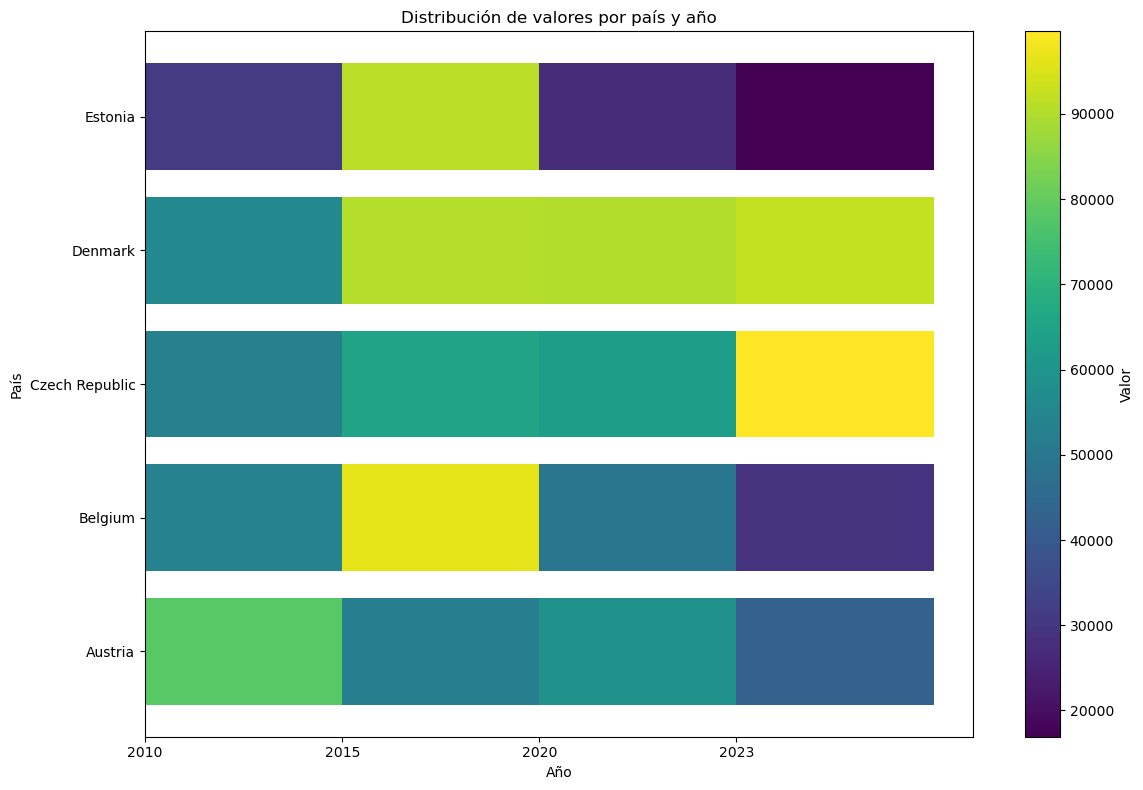

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Crear datos artificiales
np.random.seed(0)
years = [2010, 2015, 2020, 2023]
countries = ['Austria', 'Belgium', 'Czech Republic', 'Denmark', 'Estonia']
data = {
    'year': np.repeat(years, len(countries)),
    'country_name': countries * len(years),
    'value': np.random.randint(10000, 100000, size=len(countries) * len(years))
}

# Transformar los datos para el gráfico
pivot_data = df.pivot(index='country_name', columns='year', values='value')

fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.get_cmap('viridis')  
norm = mcolors.Normalize(vmin=df['value'].min(), vmax=df['value'].max())

for i, country in enumerate(pivot_data.index):
    values = pivot_data.loc[country]
    left = 0
    for year, value in values.items():
        ax.barh(country, width=1, left=left, color=cmap(norm(value)))
        left += 1

ax.set_xlabel('Año')
ax.set_ylabel('País')
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years)
ax.set_title('Distribución de valores por país y año')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Valor')

plt.tight_layout()
plt.show()


In [18]:
pivot_data

year,2010,2015,2020,2023
country_name,,,,
Austria,78268,51993,58600,42230
Belgium,53567,96293,49512,28983
Czech Republic,52613,65026,62620,99688
Denmark,55891,90471,90186,92457
Estonia,31243,90966,27089,16921


In [9]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

# Function to scrape IMDb based on title type, user rating, and release dates
def scrape_imdb(title_type, user_rating, start_date, end_date):
    url = f"https://www.imdb.com/search/title/?title_type={title_type}&release_date={start_date},{end_date}&user_rating={user_rating},10"
    
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Get the total number of movies
    total_movies = int(soup.find('div', class_='desc').find('span').text.split('of')[-1].split('titles')[0].strip())
    
    # Calculate the number of pages
    pages = total_movies // 50 + (1 if total_movies % 50 != 0 else 0)
    
    movies = []

    for page in range(1, pages * 50, 50):
        url_page = url + f'&start={page}&ref_=adv_nxt'
        response_page = requests.get(url_page)
        soup_page = BeautifulSoup(response_page.content, 'html.parser')
        
        for div in soup_page.find_all('div', class_='lister-item mode-advanced'):
            # Get movie details
            nr = div.find('span', class_='lister-item-index unbold text-primary').text.strip('.').strip()
            title = div.find('h3').find('a').text.strip()
            year = div.find('span', class_='lister-item-year text-muted unbold').text.strip('()')
            rating = div.find('strong').text
            runtime = div.find('span', class_='runtime').text.strip(' min') if div.find('span', class_='runtime') else None
            genre = div.find('span', class_='genre').text.strip() if div.find('span', class_='genre') else None
            description = div.find_all('p', class_='text-muted')[1].text.strip()
            director_and_stars = div.find('p', class_='').find_all('a')
            director = director_and_stars[0].text if director_and_stars else 'N/A'
            stars = ', '.join([a.text for a in director_and_stars[1:]]) if director_and_stars else 'N/A'
            votes = div.find('span', attrs={'name': 'nv'})['data-value'] if div.find('span', attrs={'name': 'nv'}) else None
            gross = div.find_all('span', attrs={'name': 'nv'})[1]['data-value'] if len(div.find_all('span', attrs={'name': 'nv'})) > 1 else None

            # Create a dictionary with movie details
            movie_details = {'Movie Nr': nr, 'Title': title, 'Year': year, 'Rating': rating, 'Runtime (min)': runtime, 
                             'Genre': genre, 'Description': description, 'Director': director, 
                             'Stars': stars, 'Votes': votes, 'Gross ($M)': gross}

            # Append the dictionary to the movies list
            movies.append(movie_details)
    
    # Create a DataFrame from the movies list
    df = pd.DataFrame(movies)
    return df

# Get the DataFrame by calling the function with the desired parameters
df = scrape_imdb(title_type='feature', user_rating='7.5', start_date='1990-01-01', end_date='1992-12-31')

# Display the DataFrame
df

AttributeError: 'NoneType' object has no attribute 'find'